# Assigment

The following notebook contains the base architecture for the assignment.

The task is to complete the missing parts, explore the datasets and build two simple binary classifier, one which consists only of fully connected layers and one which also incorporates convolutional and max-pooling layers.

Only numpy is allowed to implement the classes! (Matplotlib and other modules can be used for visualization and data exploration.)

**Due date:** 2019 december 3

In [0]:
import numpy as np
#For Data Visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from tabulate import tabulate

# Optimizers

In [0]:
class Optimizer:
  def update(self, param, grad):
    pass
  
  def __call__(self, param, grad):
    self.update(param, grad)
  
  
class SGD(Optimizer):
  def __init__(self, learning_rate):
    self.learning_rate = learning_rate
  
  def update(self, param, grad):
    '''Gradient Descent Update
    This function updates the given 'param' using the 'grad' (gradients). 
    Note #1: Use the learning_rate. 
    Note #2: There are no return values.
    
    :param param: Parameters of the layer.
    :param grad: Corresponding gradients.

    '''
    param = param + (self.learning_rate * -1.0 ) * grad  # DONE //
    

# Weight Initializers

In [0]:
class WeigthInitializer:
  def initialize(self, size):
    return np.ones(size, dtype=np.float)
  
  def __call__(self, size):
    return self.initialize(size)
  

class RandomInitializer(WeigthInitializer):
  def __init__(self, shift=-0.5, scale=0.2):
    self.shift = shift
    self.scale = scale
    
  def initialize(self, size):
    '''Random number initializer
    Note #1: 'self.scale' specifies the range of the values and with 'self.shift' they can be shifted.
    Note #2: By default (with scale=0.2 and shift=-0.5) it should return a matrix which contains random values between -0.1 and 0.1. 
    Note #3: Use the np.random modul!

    :param size: Dimensions of the matrix.
    :returns: A matrix of random numbers with dimensions specified by 'size'. 
    '''
    mat = np.random.random(size) + self.shift
    result = mat * self.scale
    return result  # DONE //

# Function class

In [0]:
class Function:
  def forward(self, input):
    return None  
  
  def __call__(self, input):
    return self.forward(input)
  
  def backward(self, grads):
    return None

## Activation functions

In [0]:
class Activation(Function):
  def __init__(self):
    pass
  
  
class Linear(Activation):
  def forward(self, z):
    return z.astype(np.float)

  def backward(self, z):
    return np.ones_like(z, dtype=np.float)


class Relu(Activation):
  def forward(self, z):
    '''Forward pass of the Rectified Linear Unit activation function.

    :param z: Input tensor.
    :returns: ReLU(z), see the lecture notes for the definition. 
    '''
    return np.maximum(0, z)  # DONE //

  def backward(self, z):
    '''Backward pass of the Rectified Linear Unit activation function.

    :param z: Input tensor.
    :returns: ReLU'(z), see the lecture notes for the definition. 
    '''
    return np.where(z > 0, 1, 0)  # DONE //

class Sigmoid(Activation):
  def forward(self, z):
    '''Forward pass of the Sigmoid activation function.

    :param z: Input tensor.
    :returns: sigmoid(z), see the lecture notes for the definition. 
    '''
    return 1.0 / (1.0 + np.exp(-1.0 * z))  # TODO
  
  def backward(self, z):
    '''Backward pass of the Sigmoid activation function.

    :param z: Input tensor.
    :returns: sigmoid'(z), see the lecture notes for the definition. 
    '''
    sig = 1.0 / (1.0 + np.exp(-1.0 * z))
    return sig * (1.0 - sig)  # TODO


## Loss functions

In [0]:
class Loss(Function):
  def forward(self, y_true, y_pred):
    return None
  
  def __call__(self, y_true, y_pred):
    return self.forward(y_true, y_pred)
  
  def backward(self, y_true, y_pred):
    return None
  
  
class BinaryCrossentropy(Loss):
  
  def forward(self, y_true, y_pred):
    '''Forward pass of the Binary Crossentropy loss.
    Note: Both 'y_true' and 'y_pred' contains a batch of labels => y_true.shape == y_pred.shape == <batch size> x 1 

    :param y_true: Ground truth labels.
    :param y_pred: Predicted labels.
    :returns: Binary crossentropy loss, see the lecture notes for the definition. 
    '''
    epsilon = 0.0000000001
    yshape = y_pred.shape[0]    
    result = (1./yshape) * (-np.dot(y_true,np.log(y_pred + epsilon)) - np.dot(1-y_true, np.log(1-y_pred + epsilon)))
    
    return np.sum(result)       # DONE  //

  def backward(self, y_true, y_pred):
    
    '''Backward pass of the Binary Crossentropy loss.
    Note #1: The gradient should have the same shape as y_pred (<batch size> x 1) 
    Note #2: Keep in mind that the derivative of the loss in the lecture notes is for a logistic regression model. 
    Note #3: Here, you do not need to derive respect to the weights! 

    :param y_true: Ground truth labels.
    :param y_pred: Predicted labels.
    :returns: Derivative of the binary crossentropy loss, see the lecture notes for the "definition". 
    '''
    epsilon = 0.0000000001
    yshape = y_pred.shape[0]
    y_true = y_true.reshape(y_pred.shape)
    result = -y_true/(y_pred + epsilon) + (1-y_true)/((1-y_pred) + epsilon)
    return result / yshape   # DONE  //


## Layers

In [0]:
class Layer(Function):
  def __init__(self, activation, optimizer=None, weight_init=RandomInitializer(), *args, **kwargs):
    self.activation = activation
    self.optimizer = optimizer
    self.weight_init = weight_init
  
  def _forward(self, x):
    return None
  
  def forward(self, X):
    self.X = X
    self.Z = self._forward(X)
    self.h = self.activation(self.Z)
    return self.h
  
  def _backward(self, dZ):
    return None, None
  
  def backward(self, dh):
    dZ = dh * self.activation.backward(self.Z)
    self.dX, self.grads = self._backward(dZ)
    self._update_weights()
    return self.dX
  
  def _update_weights(self):
    assert len(self.params) == len(self.grads)
    for idx in range(len(self.params)):
      self.optimizer(self.params[idx], self.grads[idx])

### Fully-connected (dense) layer

In [0]:
class Dense(Layer):
  def __init__(self, size, *args, **kwargs):
    super(Dense, self).__init__(*args, **kwargs)
    self.W = self.weight_init(size)
    self.b = self.weight_init((1, size[1]))
    self.params = [self.W, self.b]
    
  def _forward(self, X):
    '''Forward pass of the dense layer.
    Note #1: Use self.W and self.b
    Note #2: Input times weight add a bias ==> activate is already taken care of! (see self.forward())

    :param X: Input matrix
    :returns: Linear combination, see the lecture notes for the definition.
    '''
    return np.dot(X,self.W) + self.b   # DONE  //

  def _backward(self, dZ):
    '''Backward pass of the dense layer.
    Note: Use self.X

    :param dZ: Gradient of the subsequent layer.
    :returns: A pair (dX and [dW, db]) which contains the partial derivatives respect to the input and to the parameters (W and b). See the lecture notes for the "definition".
    '''
    dW = np.dot(self.X.T, dZ)   # DONE  //
    db = np.sum(dZ, axis = 0)   # DONE  //
    dX = np.dot(dZ, self.W.T)   # DONE  //
    return dX, [dW, db]

### Flatten

In [0]:
class Flatten(Layer):
  def __init__(self, *args, **kwargs):
    super(Flatten, self).__init__(activation=Linear(), *args, **kwargs)
  
  def _forward(self, X):
    return X.reshape((len(X), -1))

  def _backward(self, dZ):
    return dZ.reshape(self.X.shape), []
  
  def _update_weights(self):
    pass

### Max pooling

In [0]:
class Maxpool2d(Layer):
  def __init__(self, *args, **kwargs):
    super(Maxpool2d, self).__init__(activation=Linear(), *args, **kwargs)
  
  def _forward(self, X):
    
    '''Forward pass of the max pooling layer.
    :param X: Input matrix
    :returns: Matrix (<batch_size> x <height>//2 x <width>//2 x <n_channels>) after max pooling, see the lecture notes for the definition.
    '''    
    shaping = X.reshape(X.shape[0],X.shape[1]//2, 2,X.shape[2]//2, 2,X.shape[3])
    result = shaping.max(axis=2).max(axis=3)
    mask = np.isclose(X,np.repeat(np.repeat(result,2,axis=1),2,axis=2)).astype(int)
    self.mask = mask  # TODO save the mask for later (_backward) use.
    return result  # TODO

  def _backward(self, dZ):
    '''Backward pass of the max pooling layer.
    Note: Use self.mask too.

    :param dZ: Gradient of the subsequent layer.
    :returns: A pair (dX and []) which contains the partial derivative respect to the input and an empty list. See the lecture notes for the "definition".
    '''
    dX = self.mask * (np.repeat(np.repeat(dZ, 2, axis=1), 2, axis=2))  # TODO
    return dX, []
  
  def _update_weights(self): 
    pass

### Convolutional layer

In [0]:

class Conv2d(Layer):
  def __init__(self, kernel_size, n_channels, n_kernels, pad, use_fast=False, *args, **kwargs):    
    super(Conv2d, self).__init__(*args, **kwargs)
    self.W = self.weight_init((kernel_size, kernel_size, n_channels, n_kernels))
    self.b = self.weight_init((1, 1, 1, n_kernels))
    self.params = [self.W, self.b]
    self.pad = pad
    self.use_fast = use_fast
    

  def _convolution_fast(self, Y):
    '''Optimized version of the convolution operation (Optional).
    Note #1: Use self.X, self.X_padded, self.W
    Note #2: There are no return values.
    Note #3: It's an optional task.
    
    :param Y: Destination (output) matrix (image), see the lecture notes for the "definition". 
    '''    
    pass  # TODO optional
  
  #defined function for slicing
  def slicing(self, input, W, b):    
    return np.sum(np.multiply(input, W)) + float(b)
   
  def _convolution_slow(self, Y):
    y_height = Y.shape[1] - self.W.shape[0] + 2*self.pad + 1
    y_width = Y.shape[2] - self.W.shape[1] + 2*self.pad + 1
    Y = np.zeros((self.X.shape[0], y_height, y_width, self.W.shape[3]), dtype=np.float16)
    X_pad = self.X_padded
    for i in range(self.X.shape[0]):
        x = X_pad[i]
        for h in range(y_height):
            for w in range(y_width):
                vstart = h
                vend = vstart + self.kernel_size
                hstart = w
                hend = hstart + self.kernel_size
                for c in range(self.kernel_size):
                    seperate = x[vstart: vend, hstart: hend, :]
                    Y[i, h, w, c] = self.slicing(seperate, self.params[0][:, :, :, c],self.params[1][:, :, :, c])

    '''Naive version (with a bunch of for loops) of the convolution operation.
    Note #1: Use self.X, self.X_padded, self.W
    Note #2: There are no return values.
    Note #3: Both convolution and cross-correlation is acceptable.
    
    :param Y: Destination (output) matrix (image), see the lecture notes for the "definition". 
    '''    
    #pass  # TODO

  def _forward(self, X):
    y_height = X.shape[1] - self.W.shape[0] + 2*self.pad + 1
    y_width = X.shape[2] - self.W.shape[1] + 2*self.pad + 1
    Y = np.zeros((X.shape[0], y_height, y_width, self.W.shape[3]), dtype=np.float16)
    
    if 0 < self.pad:
      X_padded = np.pad(X, ((0, 0), (self.pad, self.pad), (self.pad, self.pad), (0, 0)), 'constant', constant_values=(0, 0)) # TODO pad the input
    else:
      X_padded = X
    self.X_padded = X_padded
    
    if self.use_fast:
      self._convolution_fast(Y)
    else:
      self._convolution_slow(Y)
    
    Y += self.b
    return Y
  
  def _backward_fast(self, dZ):
   
    '''Optimized version of the backward pass (Optional).
    Note #1: Use self.X, self.X_padded, self.W
    Note #2: It's an optional task.
    
    :param dZ: Gradient of the subsequent layer.
    :returns: A pair (dX, dW and db) which contains the partial derivatives respect to the input and to the parameters (W and b). See the lecture notes for the "definition".
    '''    
    db = None  # None optional
    dW = None  # None optional
    dX = None  # None optional
    return dX, dW, db

  def _backward_slow(self, dZ):
    '''Naive version (with a bunch of for loops) of the backward pass.
    Note: Use self.X, self.X_padded, self.W
    
    :param dZ: Gradient of the subsequent layer.
    :returns: A pair (dX, dW and db) which contains the partial derivatives respect to the input and to the parameters (W and b). See the lecture notes for the "definition".
    '''    
    db = None  # None
    dW = None  # None
    dX = None  # None 
    return dX, dW, db
  
  def _backward(self, dZ):
    if self.use_fast:
      dX, dW, db = self._backward_fast(dZ)
    else:
      dX, dW, db = self._backward_slow(dZ)
    
    if 0 < self.pad:
      dX = dX[:, self.pad:-self.pad, self.pad:-self.pad, :]
    
    return dX, [dW, db]


# Model class

In [0]:
class Model:
  def __init__(self, layers=None, loss=None, optimizer=None):
    self.layers = []
    if layers is not None:
      self.layers = layers
    self.loss = loss
    self.optimizer = optimizer
  
  def add(self, layer):
    assert isinstance(layer, Layer)
    layer.optimizer = self.optimizer
    self.layers.append(layer)
  
  def train(self, x_train, y_train, n_epochs, batch_size, randomize=True, display=True):
    self.losses = []
    for epoch in range(n_epochs):
      idx_list = list(range(len(x_train)))
      if randomize:
        np.random.shuffle(idx_list)
      n_batches = (len(idx_list) + batch_size - 1) // batch_size
      loss = 0.
      for batch_idx in range(n_batches):
        data = x_train[idx_list[batch_idx * batch_size:(batch_idx + 1) * batch_size]]
        # TODO forward pass
        
        for layer in self.layers:
          data = layer.forward(data)
        # loss
        y_pred = data
        y_true = y_train[idx_list[batch_idx * batch_size:(batch_idx + 1) * batch_size]]
        batch_loss = self.loss(y_true, y_pred)
        loss += batch_loss

        # TODO backward pass
        dx = self.loss.backward(y_true, y_pred)
        for layer in reversed(self.layers):
          dx = layer.backward(dx)

        # display
        #print('Epoch {}/{}: batch {}/{}: batch_loss: {}, avg_loss: {}'.format(epoch+1, n_epochs, batch_idx+1, n_batches, batch_loss, loss/(batch_idx+1)))  #, end='\r')
      print('Epoch {}/{}: loss: {}'.format(epoch+1, n_epochs, loss/n_batches))
      self.losses.append(loss / n_batches)
    if display:
      # pass # TODO Plot the learning curve after training.     
      plt.plot(self.losses, label='losses')
      plt.title('model Losses')
      plt.xlabel('Epoch')
      plt.ylabel('Loss')
      plt.legend(loc='lower right')

  def predict(self, x_test,y_test, display=True):
    for layer in self.layers:
      data = layer.forward(x_test)    
    y_pred = x_test
    y_true = y_test
    acc = np.equal(y_true, np.round(y_pred)).mean()
    print('Accuracy: {}'.format(acc*100)) #Done  //
    

# Breast Cancer Wisconsin (Diagnostic) Dataset

For more information, see: https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)

In [188]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data

--2019-12-15 21:05:25--  https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 124103 (121K) [application/x-httpd-php]
Saving to: ‘wdbc.data.6’

wdbc.data.6         100%[===================>] 121.19K   646KB/s    in 0.2s    

2019-12-15 21:05:25 (646 KB/s) - ‘wdbc.data.6’ saved [124103/124103]



In [189]:
filename = 'wdbc.data'

with open(filename, 'r') as file:
  lines = file.readlines()
  
words = [line.split(',') for line in lines]
data = words[:-1]

features = [[float(item) for item in rec[2:]] for rec in data]
features = np.array(features, dtype=np.float32)

label_str_to_num = lambda label: 1. if label == 'M' else 0.
labels = [label_str_to_num(rec[1]) for rec in data]
labels = np.array(labels, dtype=np.float32)

# removing records with missing features (if any feature == 0.)
missing_features = np.any(features == 0., axis=1)
features = features[~missing_features,:]
labels = labels[~missing_features]

print(features.shape)
print(labels.shape)

(556, 30)
(556,)


## Data exploration and Pre-processing
Tasks:
* Print the distribution of the labels.
* Print the scales of each features. (min, max, avg, std)
* Randomly split the dataset to training and test sets. (Ratio should be 80-20.)
  * After splitting make sure that the distribution of the labels are similar. (Print the distribution of the labels.)
* Normalize the data by each feature. (Use Z-score standardization.)

The Data has explored in tabular form where first column contains ID, 2nd column contains diagnosis and other columns contains information like Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei, Bland Chromatin, Normal Nucleoli,Mitoses. 

In [190]:
header = ["id","diagnosis","radius_mean","texture_mean","perimeter_mean","area_mean","smoothness_mean","compactness_mean","concavity_mean","concave_points_mean","symmetry_mean","fractal_dim_mean"," radius_se"," texture_se"," perimeter_se"," area_se","smoothness_se","compactness_se","concavity_se","concave_points_se"," symmetry_se"," fractual_dim_se","radius_worst","texture_worst","perimeter_worst","area_worst","smoothness_worst","compactness_worst","concavity_worst","concave_points_worst","symmetry_worst","fractal_dimension_worst"]
print(tabulate(data, headers=header))

       id  diagnosis      radius_mean    texture_mean    perimeter_mean    area_mean    smoothness_mean    compactness_mean    concavity_mean    concave_points_mean    symmetry_mean    fractal_dim_mean     radius_se     texture_se     perimeter_se     area_se    smoothness_se    compactness_se    concavity_se    concave_points_se     symmetry_se     fractual_dim_se    radius_worst    texture_worst    perimeter_worst    area_worst    smoothness_worst    compactness_worst    concavity_worst    concave_points_worst    symmetry_worst    fractal_dimension_worst
---------  -----------  -------------  --------------  ----------------  -----------  -----------------  ------------------  ----------------  ---------------------  ---------------  ------------------  ------------  -------------  ---------------  ----------  ---------------  ----------------  --------------  -------------------  --------------  ------------------  --------------  ---------------  -----------------  ------------  --

Text(0, 0.5, 'Total number of values')

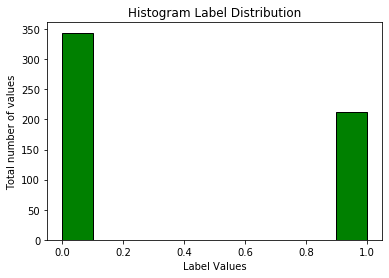

In [191]:
plt.hist(labels, color = 'green', edgecolor = 'black')
plt.title('Histogram Label Distribution')
plt.xlabel('Label Values')
plt.ylabel('Total number of values')

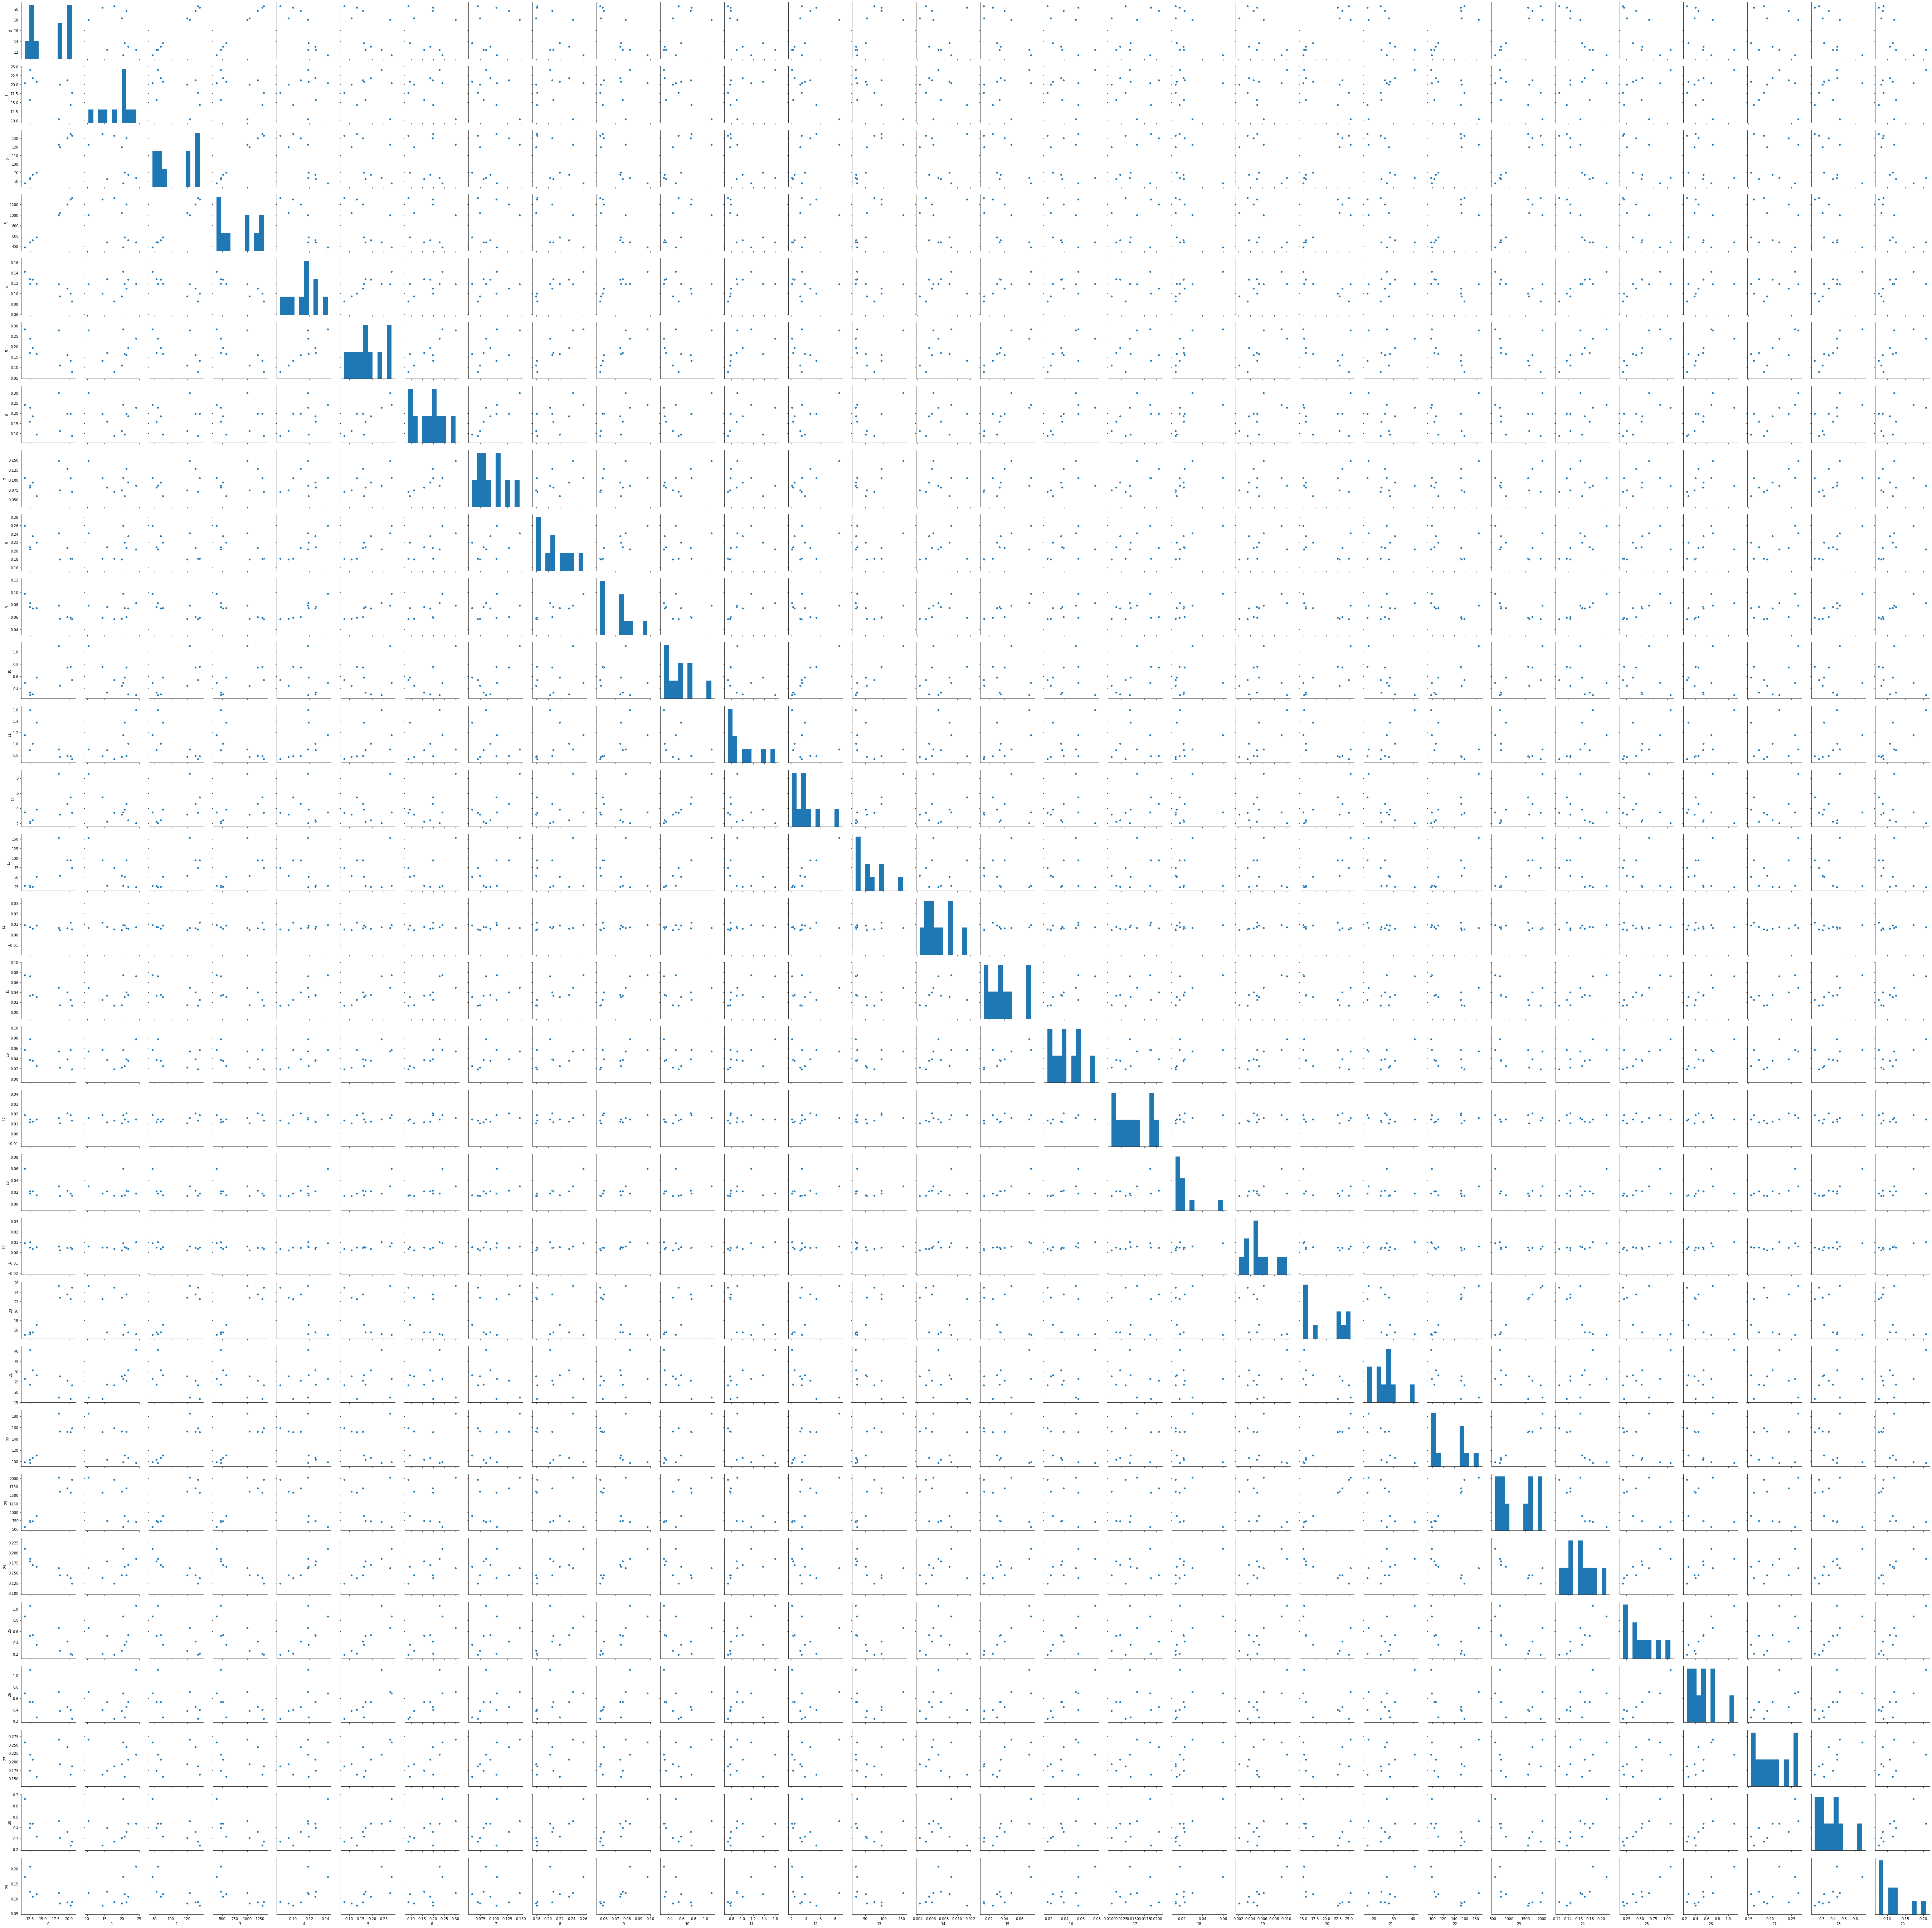

In [192]:
import pandas as pd
df = pd.DataFrame(features)
#It takes long time
#sns.pairplot(df[:10])

In [193]:
count=0
mi=[];mx=[];ag=[];std=[]
head=["radius_mean","texture_mean","perimeter_mean","area_mean","smoothness_mean","compactness_mean","concavity_mean","concave_points_mean","symmetry_mean","fractal_dim_mean"," radius_se"," texture_se"," perimeter_se"," area_se","smoothness_se","compactness_se","concavity_se","concave_points_se"," symmetry_se"," fractual_dim_se","radius_worst","texture_worst","perimeter_worst","area_worst","smoothness_worst","compactness_worst","concavity_worst","concave_points_worst","symmetry_worst","fractal_dimension_worst"]

for i in np.arange(features.shape[1]):
  mi.append(np.min(features[i]))
  mx.append(np.max(features[i]))
  ag.append(np.average(features[i]))
  std.append(np.std(features[i]))
  count+=1

table = [head,mi,mx,ag,std]
df = pd.DataFrame(table)
df = df.transpose()
df.columns = ["Feature_name","Minimum","Maximum","Average","Std"]

df

,Feature_name,Minimum,Maximum,Average,Std
0,radius_mean,0.006193,2019,118.873,397.013
1,texture_mean,0.003532,1956,124.697,415.051
2,perimeter_mean,0.004571,1709,112.913,366.81
3,area_mean,0.00911,567.7,41.3334,120.848
4,smoothness_mean,0.005115,1575,111.223,357.933
5,compactness_mean,0.005082,741.6,50.1848,155.081
6,concavity_mean,0.002179,1606,102.265,336.145
7,concave_points_mean,0.005412,897,60.4813,187.397
8,symmetry_mean,0.003749,739.3,52.1632,158.796
9,fractal_dim_mean,0.007149,711.4,49.7811,150.334


x train:  (444, 30)
x test:  (112, 30)
y train:  (444,)
y test:  (112,)


Text(0, 0.5, 'Total number of values')

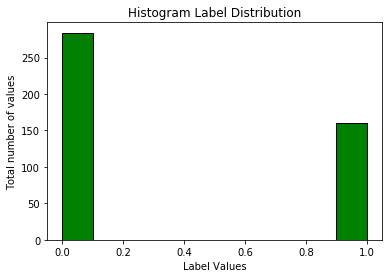

In [194]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features,labels, test_size = 0.2, random_state=42)

print("x train: ", X_train.shape) 
print("x test: ", X_test.shape) 
print("y train: ", y_train.shape) 
print("y test: ", y_test.shape) 


plt.hist(y_train, color = 'green', edgecolor = 'black')
plt.title('Histogram Label Distribution')
plt.xlabel('Label Values')
plt.ylabel('Total number of values')


In [195]:
#Normalization
from scipy.stats import zscore
X_train_normed = zscore(X_train)
X_test_normed = zscore(X_test)

print(X_train_normed.shape)
print(X_test_normed.shape)

print(tabulate(X_train_normed, headers=head))


(444, 30)
(112, 30)
  radius_mean    texture_mean    perimeter_mean    area_mean    smoothness_mean    compactness_mean    concavity_mean    concave_points_mean    symmetry_mean    fractal_dim_mean     radius_se     texture_se     perimeter_se       area_se    smoothness_se    compactness_se    concavity_se    concave_points_se     symmetry_se     fractual_dim_se    radius_worst    texture_worst    perimeter_worst    area_worst    smoothness_worst    compactness_worst    concavity_worst    concave_points_worst    symmetry_worst    fractal_dimension_worst
-------------  --------------  ----------------  -----------  -----------------  ------------------  ----------------  ---------------------  ---------------  ------------------  ------------  -------------  ---------------  ------------  ---------------  ----------------  --------------  -------------------  --------------  ------------------  --------------  ---------------  -----------------  ------------  ------------------  ------

## Define and train a model.
Tasks:
* Define a 2 layer fully-connected network:
  1. layer with 5 units and ReLU activation.
  2. layer with 1 units and Sigmoid activation.
* Train it for 500 epochs with a batch size of 16 using SGD optimizer with learning rate of 0.01.
* Plot the learning curve.
  * Summmarize in a few words what you see. (Presence of overfitting, underfitting, ...)
* Evaluate the trained model on the test set. (Loss, accuracy, precision, recall)

Epoch 1/500: loss: 0.6994659016756938
Epoch 2/500: loss: 0.6993802526371528
Epoch 3/500: loss: 0.6995170264500956
Epoch 4/500: loss: 0.6993591893964377
Epoch 5/500: loss: 0.6994211845485789
Epoch 6/500: loss: 0.6995484421013003
Epoch 7/500: loss: 0.699382570102946
Epoch 8/500: loss: 0.6993984403960027
Epoch 9/500: loss: 0.6993754006109328
Epoch 10/500: loss: 0.6993725397428519
Epoch 11/500: loss: 0.6993724425843606
Epoch 12/500: loss: 0.6994361583426231
Epoch 13/500: loss: 0.6995072738861634
Epoch 14/500: loss: 0.6994470975688631
Epoch 15/500: loss: 0.6993641710151692
Epoch 16/500: loss: 0.6992708045423109
Epoch 17/500: loss: 0.6994473759399116
Epoch 18/500: loss: 0.6994577293322459
Epoch 19/500: loss: 0.6993205509015502
Epoch 20/500: loss: 0.6994966688943668
Epoch 21/500: loss: 0.6994446800930522
Epoch 22/500: loss: 0.6994133686740163
Epoch 23/500: loss: 0.6993363946827564
Epoch 24/500: loss: 0.6993869607165913
Epoch 25/500: loss: 0.6995320229470059
Epoch 26/500: loss: 0.6993380147444

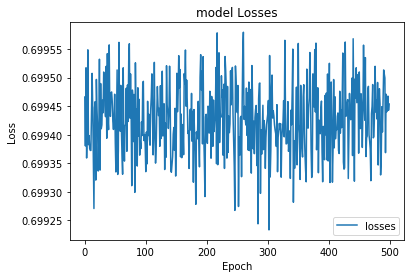

In [196]:
np.random.seed(0)
# TODO
epoch = 500  
bsize = 16  #Batch Size
lrate = 0.01    #Learning Rate
opt = SGD(learning_rate=lrate)
loss_call = BinaryCrossentropy()
model = Model(loss=loss_call, optimizer = opt)
model.add(Dense(size = (X_train_normed.shape[1],5), activation = Relu()))
model.add(Dense(size = (5,1), activation = Sigmoid()))

model.train(X_train_normed, y_train, epoch , bsize)



In [197]:
model.predict(X_test_normed, y_test)


Accuracy:  58.14


The accuracy of the model is too low and has high loss. It show that the model is underfitting.


Below, I have implemented the model in Tensorflow. 

In [0]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import optimizers
from keras import backend as K
import keras

In [0]:
def recall_m(y_true, y_pred):
        true_positives = keras.backend.sum(keras.backend.round(keras.backend.clip(y_true * y_pred, 0, 1)))
        possible_positives = keras.backend.sum(keras.backend.round(keras.backend.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = keras.backend.sum(keras.backend.round(keras.backend.clip(y_true * y_pred, 0, 1)))
        predicted_positives = keras.backend.sum(keras.backend.round(keras.backend.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision * recall)/(precision + recall + keras.backend.epsilon()))

In [0]:
nn = tf.keras.Sequential([
    #tf.keras.layers.Flatten(input_shape=(X_train_normed.shape[1], )),
    tf.keras.layers.Dense(5, activation='relu', input_shape=(X_train_normed.shape[1], )),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [201]:
nn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 5)                 155       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 6         
Total params: 161
Trainable params: 161
Non-trainable params: 0
_________________________________________________________________


In [0]:
#opt = tf.keras.optimizers.Adam(lr=0.01)
#opt = tf.keras.optimizers.SGD(lr=0.01)
opt = tf.keras.optimizers.SGD(lr=0.01, decay=1e-6)
nn.compile( loss='binary_crossentropy', optimizer=opt, metrics=['accuracy',
                                                                  f1_m,
                                                                  precision_m,
                                                                  recall_m])

In [0]:
history = nn.fit(X_train_normed, y_train, batch_size = 16, epochs=500,verbose=0,validation_data=(X_test_normed, y_test))

In [204]:
loss, accuracy, f1_score, precision, recall = nn.evaluate(X_test_normed, y_test, verbose=0)
print("Loss: ",loss,"\nAccuracy: ", accuracy,"\nF1_score: ", f1_score,"\nPrecision:  ",precision,"\nRecall: " ,recall)

Loss:  0.260057087455477 
Accuracy:  0.9464286 
F1_score:  0.9384775 
Precision:   1.0 
Recall:  0.8843932


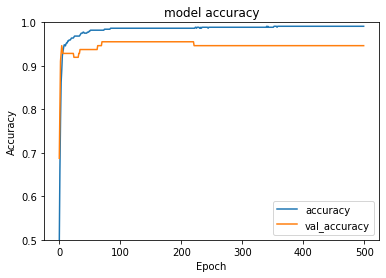

In [205]:
plt.plot(history.history['acc'], label='accuracy')
plt.plot(history.history['val_acc'], label = 'val_accuracy')
plt.title('model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

(0, 1)

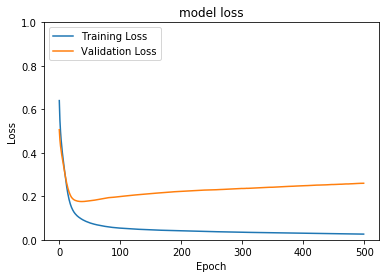

In [206]:
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.title('model loss')
plt.legend(loc='upper left')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])

# Triangles vs Circles (Basic Shapes Dataset)

For more information, see: https://www.kaggle.com/cactus3/basicshapes

In [207]:
!curl -c ./cookie -s -L "https://drive.google.com/uc?export=download&id=1Va88vwMwmToi0SFfdTo8_9TJsV4qdOXK" > /dev/null
!curl -Lb ./cookie "https://drive.google.com/uc?export=download&confirm=`awk '/download/ {print $NF}' ./cookie`&id=1Va88vwMwmToi0SFfdTo8_9TJsV4qdOXK" -o circles_vs_triangles_data.pkl

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0   2179      0 --:--:-- --:--:-- --:--:--  2167
100  153k  100  153k    0     0   524k      0 --:--:-- --:--:-- --:--:--  524k


In [0]:
import pickle

with open('circles_vs_triangles_data.pkl', 'rb') as f:
    data = pickle.load(f)
features, labels = data['features'], data['labels']

## Data exploration and Pre-processing
Tasks:
* Print the distribution of the labels.
* Plot some images (3 circles and 3 triangles).
* Randomly split the dataset to training and test sets. (Ratio should be 80-20.)
  * After splitting make sure that the distribution of the labels are similar. (Print the distribution of the labels.)
* Normalize the data between -1. and 1. (Use min-max scaling.)

Text(0, 0.5, 'Total number of values')

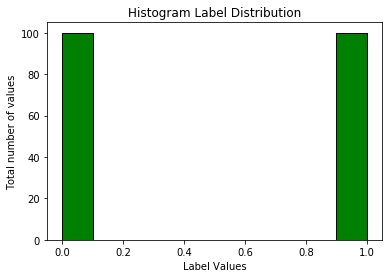

In [209]:
plt.hist(labels, color = 'green', edgecolor = 'black')
plt.title('Histogram Label Distribution')
plt.xlabel('Label Values')
plt.ylabel('Total number of values')

Sample Random Circles: 


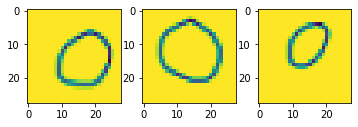


Sample Random Triangles: 


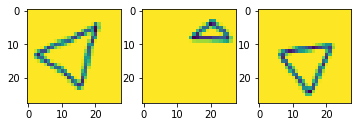

In [210]:
def print_img(l):
  fig=plt.figure(figsize=(10,10))
  for i in range(1,4):
      img = np.random.randint(10, size=(28,28))
      fig.add_subplot(5, 5, i)
      plt.imshow(np.reshape(features[np.random.choice(np.where(labels==l)[0])], [28,28]),cmap=None)
  plt.show()


print('Sample Random Circles: ')
print_img(0) # print circles
print('\nSample Random Triangles: ')
print_img(1) # print triangle


In [211]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.2, random_state = 21, shuffle=True)

print("x train: ", X_train.shape) 
print("x test: ", X_test.shape) 
print("y train: ", y_train.shape) 
print("y test: ", y_test.shape) 

x train:  (160, 28, 28, 1)
x test:  (40, 28, 28, 1)
y train:  (160, 1)
y test:  (40, 1)


Text(0, 0.5, 'Total number of values')

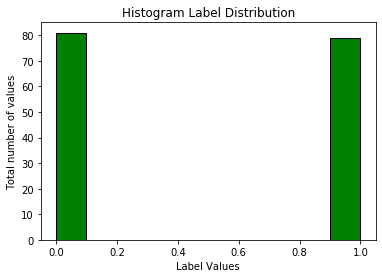

In [212]:
plt.hist(y_train, color = 'green', edgecolor = 'black')
plt.title('Histogram Label Distribution')
plt.xlabel('Label Values')
plt.ylabel('Total number of values')

In [213]:
minimum = features.min()
maximum = features.max()
X_train_norm = (X_train - minimum) / (maximum - minimum)
X_test_norm = (X_test - minimum) / (maximum - minimum)

print(X_train_norm.mean(), X_train_norm.std())
print(X_test_norm.mean(), X_test_norm.std())

0.9432060684850863 0.16238667085186864
0.9451666167479138 0.16134239188644417


## Define and train a model.
Tasks:
* Define a simple convolutional network as follows: 2x(Conv2D with 4 [then 8 in the second time] (3x3) kernels -> ReLU -> MaxPooling2D) -> Flatten -> Dense with 32 units -> Relu -> Dense -> Sigmoid
* Train it for 100 (or less if it is too slow...) epochs with a batch size of 16 using SGD optimizer with learning rate of 0.01.
  * Optional: Also train it with the optimized implementation, and measure the speed up. 
* Plot the learning curve.
  * Summmarize in a few words what you see. (Presence of overfitting, underfitting, ...)
* Evaluate the trained model on the test set. (Loss, accuracy, precision, recall)

In [214]:
np.random.seed(0)
# TODO
epochs = 100
bsize = 16
lrate = 0.01
opt = SGD(learning_rate=lrate)
loss_call = BinaryCrossentropy()
model = Model(loss=loss_call, optimizer = opt)
model.add(Conv2d(kernel_size=3, n_kernels=4, activation = Relu(), n_channels=1, pad=1))
model.add(Maxpool2d(size = 2))
model.add(Conv2d(kernel_size=3, n_kernels=8, activation = Relu(), n_channels=1, pad=1))
model.add(Maxpool2d(size = 2))
model.add(Flatten())
model.add(Dense(size = (392,32), activation = Relu()))
model.add(Dense(size = (32,1), activation = Sigmoid()))
model.train(X_train_norm, y_train, epochs , batch_size)
model.predict(X_test_norm, y_test)

TypeError: ignored

I have tried to develop the model using keras with the same given tasks. I am trying to develop this project using numpy.



In [0]:
nn = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(4, (3,3), activation='relu', input_shape = (28,28,1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Conv2D(8, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [216]:
nn.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 4)         40        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 4)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 8)         296       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 8)           0         
_________________________________________________________________
flatten (Flatten)            (None, 200)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                6432      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

In [0]:
#opt = tf.keras.optimizers.Adam(lr=0.01)
opt = tf.keras.optimizers.SGD(lr=0.01, decay=1e-6)
nn.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy',
                                                                  f1_m,
                                                                  precision_m,
                                                                  recall_m])

In [0]:
history = nn.fit(X_train_norm, y_train, epochs=100, batch_size=16, verbose=0,validation_data=(X_test_norm, y_test))

In [219]:
loss, accuracy, f1_score, precision, recall = nn.evaluate(X_test_norm, y_test, verbose=0)
print("Loss: ",loss,"\nAccuracy: ", accuracy,"\nF1_score: ", f1_score,"\nPrecision:  ",precision,"\nRecall: " ,recall)

Loss:  0.6686109304428101 
Accuracy:  0.675 
F1_score:  0.7780748 
Precision:   0.7222222 
Recall:  0.84375


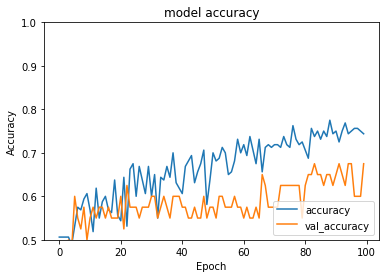

In [220]:
plt.plot(history.history['acc'], label='accuracy')
plt.plot(history.history['val_acc'], label = 'val_accuracy')
plt.title('model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')


(0, 1)

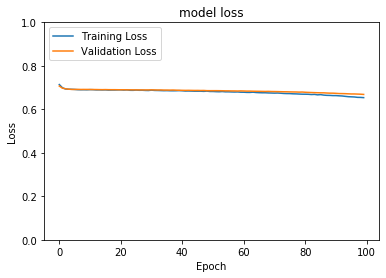

In [221]:
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.title('model loss')
plt.legend(loc='upper left')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])